In [113]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [114]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [115]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine,inspect, func

In [116]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [117]:
#inspect hawaii.sqlite file
#inspector=inspect(engine)
#inspector.get_table_names()

# reflect an existing database into a new model
Base=automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [118]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [119]:
# Save references to each table
Station=Base.classes.station
Measurement=Base.classes.measurement

In [120]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [121]:
#find the column names
inspector=inspect(engine)
columns=inspector.get_columns('measurement')
for column in columns:
    print(column['name'],column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [122]:
# Find the most recent date in the data set.
latestDate=session.query(Measurement).order_by(Measurement.date.desc()).first().date
print(f"{latestDate} is the most recent date in the data set.")

2017-08-23 is the most recent date in the data set.


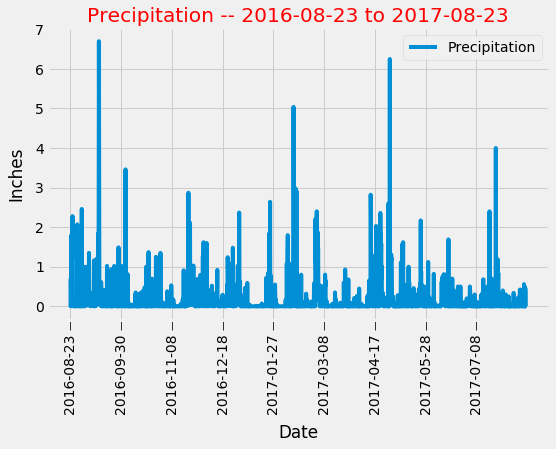

<Figure size 432x288 with 0 Axes>

In [123]:
##### Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

oneYearAgoDate=dt.date(2017,8,23)-dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
oneYearPrec=session.query(Measurement.date,Measurement.prcp)\
.filter(Measurement.date>=oneYearAgoDate).order_by(Measurement.date.desc())

# Save the query results as a Pandas DataFrame and set the index to the date column

prec_df=pd.DataFrame(oneYearPrec)
prec_df.set_index('date',inplace=True)

# Sort the dataframe by date

prec_df.sort_values('date',inplace=True)
prec_df.rename(columns={'prcp':'Precipitation'},inplace=True)
prec_df.dropna(inplace=True)


# Use Pandas Plotting with Matplotlib to plot the data

col_length=len(prec_df.iloc[::])#finds the length for the x-axis
col_div=int(round(col_length/9,0)) #finds the number to divide into col_length to get 9 ticks

ax=prec_df.plot(kind="line",rot='vertical',figsize=(8,5))#plots the graph

ax.set_xticks(range(0,col_length,1)[::col_div])#sets the xticks divided into 9 places
ax.set_xticklabels(prec_df.index[::col_div], rotation='vertical')#sets they x label into 9 places

#formats the graph
ax.set_ylabel("Inches",labelpad=10)
ax.set_xlabel("Date",labelpad=10)
ax.set_title(f"Precipitation -- {oneYearAgoDate} to {latestDate}",color='red')
ax.xaxis.set_tick_params(length=10)

plt.show()
plt.tight_layout()

In [124]:
# Use Pandas to calcualte the summary statistics for the precipitation data
total_rain=round(np.sum(prec_df['Precipitation']),2)
mean_rain=round(np.mean(prec_df['Precipitation']),2)
median_rain=round(np.median(prec_df['Precipitation']),2)
std_rain=round(np.std(prec_df['Precipitation']),2)
min_rain=np.min(prec_df['Precipitation'])
#quartile1=prec_df.quantile(.25)
#quartile2=prec_df.quantile(.50)
#quartile3=prec_df.quantile(.75)
max_rain=np.max(prec_df['Precipitation'])

#prints the summary
print()
print(f"Precipitation from {oneYearAgoDate}-{latestDate}")
print('----------------------------------------')
print(f"total:  {total_rain}")
print(f"mean:  {mean_rain}")
print(f"median:  {median_rain}")
print(f"std:  {std_rain}")
print(f"min:  {min_rain}")
#print(f"25%:  {quartile1[0]}")
#print(f"50%:  {quartile2[0]}")
#print(f"75%:  {quartile3[0]}")
print(f"max:  {max_rain}")
print()


Precipitation from 2016-08-23-2017-08-23
----------------------------------------
total:  358.28
mean:  0.18
median:  0.02
std:  0.46
min:  0.0
max:  6.7



In [125]:
#find the column names
columns=inspector.get_columns('station')
for column in columns:
    print(column['name'],column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [126]:
# Design a query to calculate the total number stations in the dataset
stationCount=session.query(Station.station).distinct().count()
print(f"There are {stationCount} stations in the data set.")

There are 9 stations in the data set.


In [127]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

ActiveStations=session.query(Measurement.station,func.count(Measurement.id),Station.name)\
    .group_by('station').filter(Station.station==Measurement.station)\
    .order_by(func.count(Measurement.id).desc()).all()

#print out results

print()
print('Most Active Stations')

station_df=pd.DataFrame(ActiveStations,columns=['station id','count','station'])
station_df


Most Active Stations


,station id,count,station
0,USC00519281,2772,"WAIHEE 837.5, HI US"
1,USC00519397,2724,"WAIKIKI 717.2, HI US"
2,USC00513117,2709,"KANEOHE 838.1, HI US"
3,USC00519523,2669,"WAIMANALO EXPERIMENTAL FARM, HI US"
4,USC00516128,2612,"MANOA LYON ARBO 785.2, HI US"
5,USC00514830,2202,"KUALOA RANCH HEADQUARTERS 886.9, HI US"
6,USC00511918,1979,"HONOLULU OBSERVATORY 702.2, HI US"
7,USC00517948,1372,"PEARL CITY, HI US"
8,USC00518838,511,"UPPER WAHIAWA 874.3, HI US"


In [128]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

#pulls the most active info
mostactive_id=station_df.iloc[0,0]
mostactive_name=station_df.iloc[0,2]

#queries the most active
most_active_temps=session.query(func.min(Measurement.tobs),\
    func.max(Measurement.tobs),func.avg(Measurement.tobs))\
    .filter(Measurement.station==mostactive_id).all()

print()
print(f"Station {mostactive_name} (most active station)")
print('----------------------------------------')
print(f"Min Temperature: {most_active_temps[0][0]}")
print(f"Max Temperature: {most_active_temps[0][1]}")
print(f"AVG Temperature: {round(most_active_temps[0][2],2)}")
print()


Station WAIHEE 837.5, HI US (most active station)
----------------------------------------
Min Temperature: 54.0
Max Temperature: 85.0
AVG Temperature: 71.66



Text(0.5, 1.0, '2772 -- 2016-08-23 to 2017-08-23')

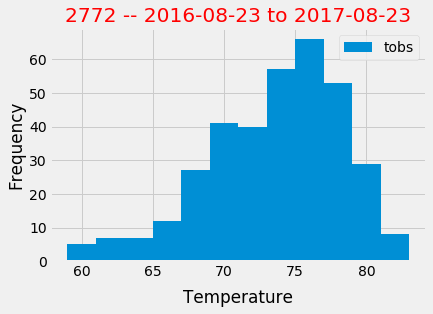

In [132]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
activeOneYearTemp=session.query(Measurement.date,Measurement.tobs)\
    .filter(Measurement.station==mostactive_id).filter(Measurement.date>=oneYearAgoDate)\
    .filter(Measurement.date<=latestDate).all()

#turn query into pandas data frame
activeOneYearTemp_df=pd.DataFrame(activeOneYearTemp)
activeOneYearTemp_df.set_index('date',inplace=True)

#plot information
ax=activeOneYearTemp_df.plot(kind='hist',bins=12)
ax.set_xlabel("Temperature",labelpad=10)
ax.set_title(f"{ActiveStations[0][1]} -- {oneYearAgoDate} to {latestDate}",color='red')



# Close session

In [131]:
# Close Session
session.close()